Link to original notebook: https://www.kaggle.com/code/qianchengqu/rosenbluth-to-perm-gpu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from tqdm.auto import tqdm
import os
import sys
from joblib import Parallel, delayed
import torch
from IPython.display import clear_output

GPU_AVAILABLE = torch.cuda.is_available()
print(f"GPU Available: {GPU_AVAILABLE}\nCUDA Version: {torch.version.cuda if GPU_AVAILABLE else 'N/A'}")

GPU Available: True
CUDA Version: 12.1


GPU-PERM SAW Simulation
Running simulation...
result: [4.0000000e+05 1.2000000e+06 3.6000000e+06 9.9909000e+06 2.8376352e+07
 7.7899152e+07 2.1676802e+08 5.8981613e+08 1.6229482e+09 4.4043377e+09
 1.2044074e+10 3.2548215e+10 8.8316010e+10 2.3764086e+11 6.4267040e+11
 1.7286764e+12 4.6519188e+12 1.2471370e+13 3.3520827e+13 8.9799537e+13
 2.4101867e+14 6.4529669e+14 1.7286179e+15 4.6250253e+15 1.2352268e+16
 3.2952333e+16 8.7952383e+16 2.3506688e+17 6.2920584e+17 1.6766998e+18
 4.4724073e+18 1.1937142e+19 3.1910174e+19 8.5303877e+19 2.2803460e+20
 6.0633235e+20 1.6100197e+21 4.2759249e+21 1.1374621e+22 3.0242635e+22
 8.0549041e+22 2.1398128e+23 5.6985628e+23 1.5167469e+24 4.0335094e+24
 1.0744153e+25 2.8663602e+25 7.6174810e+25 2.0302374e+26 5.4038707e+26]
Estimated μ = 2.662211 (理论值≈2.638)
Estimated γ = 13.597069 (理论值≈1.344)


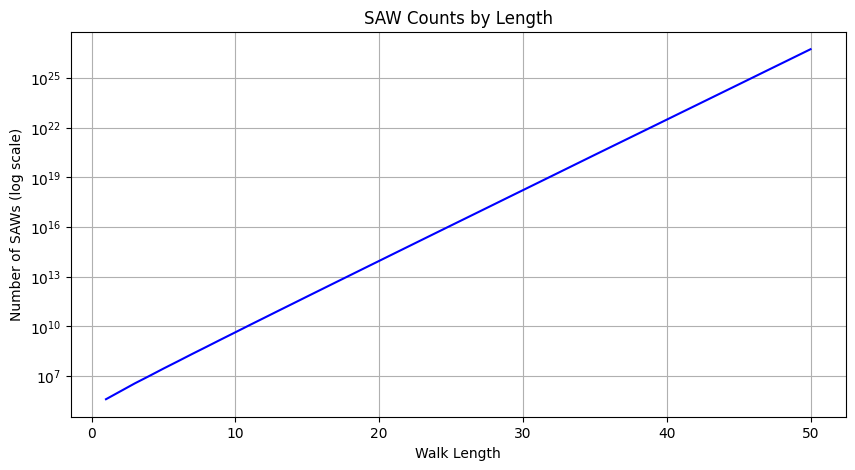

In [14]:
!pip install numba
import numpy as np
from numba import cuda, float32, int32
import math
from tqdm import tqdm

# ================== 碰撞检测方法 ==================
@cuda.jit(device=True)
def linear_collision_check(walk, length, new_pos):
    """基础线性搜索 O(n)"""
    for i in range(length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return True
    return False

@cuda.jit(device=True)
def hash_collision_check(walk, length, new_pos, grid_size=5):
    """分块空间哈希 O(n/grid_size^2)"""
    # 计算新位置所在网格
    grid_x = new_pos[0] // grid_size
    grid_y = new_pos[1] // grid_size
    
    # 只检查相同或相邻网格的点
    for i in range(max(0, length-100), length):  # 最近100点优先检查
        dx = abs(walk[i,0] - new_pos[0])
        dy = abs(walk[i,1] - new_pos[1])
        if dx < grid_size and dy < grid_size:  # 相邻网格范围
            if dx == 0 and dy == 0:
                return True
    return False

# ================== GPU核函数 ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return
    
    # 初始化随机状态（整型避免浮点位操作问题）
    seed = random_states[wid]
    rnd_state = seed
    
    # 初始化walk（使用本地内存）
    walk = cuda.local.array(shape=(128, 2), dtype=int32)  # 最大128步
    walk_length = 1
    walk[0,0] = 0
    walk[0,1] = 0
    
    weight = 1.0
    current_length = 0
    
    # 固定方向数组（替代Python列表）
    directions = cuda.local.array(shape=(4,2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0    # 右
    directions[1,0], directions[1,1] = -1, 0   # 左
    directions[2,0], directions[2,1] = 0, 1    # 上
    directions[3,0], directions[3,1] = 0, -1   # 下
    
    while current_length < max_length and walk_length < 128:
        # 生长步骤
        valid_count = 0
        valid_indices = cuda.local.array(shape=4, dtype=int32)  # 有效方向索引
        
        # 检查所有可能方向
        for d in range(4):
            new_x = walk[walk_length-1,0] + directions[d,0]
            new_y = walk[walk_length-1,1] + directions[d,1]
            
            # 选择碰撞检测方法（注释切换）
            # if not linear_collision_check(walk, walk_length, (new_x, new_y)):
            if not hash_collision_check(walk, walk_length, (new_x, new_y), 8):
                valid_indices[valid_count] = d
                valid_count += 1
        
        # PERM核心逻辑
        if valid_count > 0:
            # 生成随机索引
            rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
            move_idx = int((rnd_state / 0xFFFFFFFF) * valid_count)
            
            # 执行移动
            d = valid_indices[move_idx]
            walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
            walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
            walk_length += 1
            weight *= valid_count
            current_length += 1
            
            # 原子方式记录结果
            cuda.atomic.add(results, current_length, weight)
        else:
            break  # 无法继续生长

# ================== 主类封装 ==================
class GPUPERM:
    def __init__(self, max_length=50, num_walks=10000):
        self.max_length = max_length
        self.num_walks = num_walks
        self.results = np.zeros(max_length+1, dtype=np.float32)
        
    def run(self):
        # 配置GPU核函数
        threads_per_block = 256
        blocks = (self.num_walks + threads_per_block - 1) // threads_per_block
        
        # 准备随机状态（使用整型）
        random_states = np.random.randint(1, 2**31, size=self.num_walks, dtype=np.uint32)
        
        # 运行内核
        d_results = cuda.to_device(self.results)
        d_random = cuda.to_device(random_states)
        
        perm_gpu_kernel[blocks, threads_per_block](
            self.max_length,
            self.num_walks,
            d_results,
            d_random
        )
        
        # 获取结果
        self.results = d_results.copy_to_host()
        print(f"result: {self.results[1:self.max_length+1]}")
        return self.results[1:self.max_length+1]  # 忽略0长度

    def estimate_constants(self, fit_start=30):
        """估计μ和γ"""
        lengths = np.arange(fit_start, self.max_length+1)
        log_cn = np.log(self.results[fit_start:self.max_length+1])
        coeffs = np.polyfit(lengths, log_cn, deg=1)
        
        mu = np.exp(coeffs[0])
        gamma = coeffs[1] + 1
        return mu, gamma

# ================== 使用示例 ==================
if __name__ == "__main__":
    print("GPU-PERM SAW Simulation")
    simulator = GPUPERM(max_length=50, num_walks=100000)
    
    print("Running simulation...")
    results = simulator.run()
    mu, gamma = simulator.estimate_constants()
    
    print(f"Estimated μ = {mu:.6f} (理论值≈2.638)")
    print(f"Estimated γ = {gamma:.6f} (理论值≈1.344)")
    
    # 可视化结果
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1, simulator.max_length + 1), results, 'b-')
    plt.xlabel('Walk Length')
    plt.ylabel('Number of SAWs (log scale)')
    plt.yscale('log')
    plt.title('SAW Counts by Length')
    plt.grid(True)
    plt.show()

#### if L_max<=128: use device local memory；
#### else: use global memory

=== 短链测试 (L=50) ===


/usr/local/lib/python3.10/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


result: [4.00000000e+04 1.20000000e+05 3.60000000e+05 1.00342800e+06
 2.84893200e+06 7.81012800e+06 2.17323000e+07 5.91086160e+07
 1.63045360e+08 4.41839104e+08 1.20809165e+09 3.25972890e+09
 8.86169600e+09 2.38785065e+10 6.44702781e+10 1.73594722e+11
 4.67455312e+11 1.25851822e+12 3.38276673e+12 9.10988044e+12
 2.44932191e+13 6.55000800e+13 1.75511842e+14 4.70643791e+14
 1.25987551e+15 3.36552859e+15 9.01050638e+15 2.39920223e+16
 6.42970305e+16 1.71599783e+17 4.55231899e+17 1.22032830e+18
 3.24290757e+18 8.63419213e+18 2.30624609e+19 6.13699804e+19
 1.63318642e+20 4.33527407e+20 1.15208222e+21 3.04167968e+21
 7.95915589e+21 2.10356383e+22 5.56539755e+22 1.49015095e+23
 3.89879322e+23 1.03985889e+24 2.75340281e+24 7.41718100e+24
 1.94626178e+25 5.10681877e+25]
μ = 2.652083, γ = 11.440209

=== 长链测试 (L=200) ===
result: [4.00000000e+04 1.20000000e+05 3.60000000e+05 9.98352000e+05
 2.83770000e+06 7.77049200e+06 2.16095040e+07 5.87894760e+07
 1.62313952e+08 4.40658368e+08 1.20596902e+09 3.

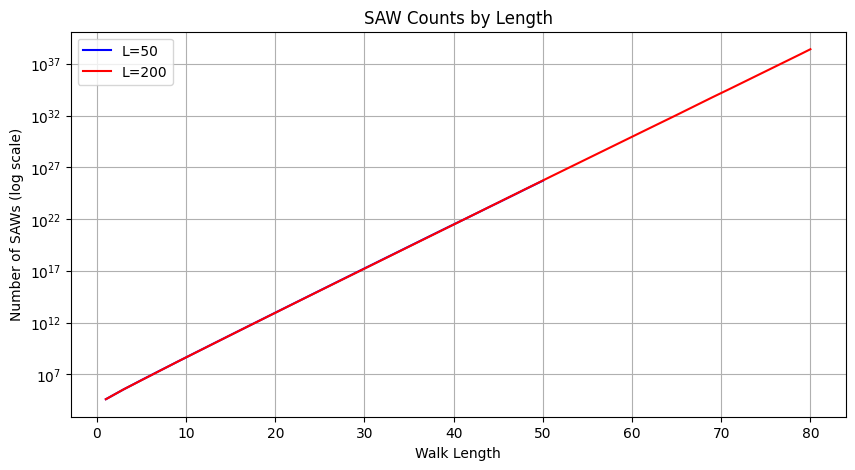

In [15]:
!pip install numba
import numpy as np
from numba import cuda, int32, float32
import math
import time

# ================== 配置参数 ==================
USE_LOCAL_MEM = True  # 设为False强制使用全局内存
LOCAL_MEM_MAX_LENGTH = 128  # 本地内存支持的最大链长

# ================== 碰撞检测 ==================
@cuda.jit(device=True)
def collision_check(walk: int32[:,:], length: int32, new_pos: int32[:], grid_size: int32) -> int32:
    """改进的碰撞检测：网格优化 + 完整检查"""
    # 优先检查最近100个点
    for i in range(max(0, length-100), length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return 1  # True
    
    # 网格优化检查
    if grid_size > 0:
        grid_x = new_pos[0] // grid_size
        grid_y = new_pos[1] // grid_size
        for i in range(length):
            dx = abs(walk[i,0] - new_pos[0])
            dy = abs(walk[i,1] - new_pos[1])
            if dx < grid_size and dy < grid_size:
                if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                    return 1  # True
    else:
        # 线性检查所有点
        for i in range(length):
            if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                return 1  # True
    return 0  # False

# ================== GPU核函数 ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states, global_walks):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return

    # ===== 内存分配策略 =====
    if max_length <= LOCAL_MEM_MAX_LENGTH and USE_LOCAL_MEM:
        walk = cuda.local.array(shape=(LOCAL_MEM_MAX_LENGTH, 2), dtype=int32)
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0
    else:
        walk = global_walks[wid]
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0

    # ===== 初始化方向数组 =====
    directions = cuda.local.array(shape=(4,2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0
    directions[1,0], directions[1,1] = -1, 0
    directions[2,0], directions[2,1] = 0, 1
    directions[3,0], directions[3,1] = 0, -1

    rnd_state = random_states[wid]
    weight = 1.0
    current_length = 0

    # 创建new_pos数组
    new_pos = cuda.local.array(2, dtype=int32)

    while current_length < max_length:
        valid_count = 0
        valid_moves = cuda.local.array(4, dtype=int32)

        # 生长步骤
        for d in range(4):
            new_pos[0] = walk[walk_length-1,0] + directions[d,0]
            new_pos[1] = walk[walk_length-1,1] + directions[d,1]

            if not collision_check(walk, walk_length, new_pos, 8):
                valid_moves[valid_count] = d
                valid_count += 1

        if valid_count == 0:
            break

        # 随机选择（改进随机数生成）
        rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
        choice = int32((rnd_state / 4294967296.0) * valid_count)  # 0xFFFFFFFF = 4294967295

        # 更新walk
        d = valid_moves[choice]
        walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
        walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
        walk_length += 1
        weight *= valid_count
        current_length += 1

        # 记录结果
        cuda.atomic.add(results, current_length, weight)

# ================== 主控制类 ==================
class AdaptivePERM:
    def __init__(self, max_length=50, num_walks=10000):
        self.max_length = max_length
        self.num_walks = num_walks
        self.results = np.zeros(max_length+1, dtype=np.float32)
        # 预分配全局内存
        self.global_walks = cuda.device_array(shape=(num_walks, max_length, 2), dtype=np.int32)
    
    def run(self):
        threads = 256  # 优化线程块大小
        blocks = (self.num_walks + threads - 1) // threads
        
        # 准备随机状态
        random_states = np.random.randint(1, 2**31, size=self.num_walks, dtype=np.uint32)
        
        # 传输数据到GPU
        d_results = cuda.to_device(self.results)
        d_random_states = cuda.to_device(random_states)
        
        # 执行核函数
        perm_gpu_kernel[blocks, threads](
            self.max_length,
            self.num_walks,
            d_results,
            d_random_states,
            self.global_walks  
        )
        
        # 获取结果
        self.results = d_results.copy_to_host()
        print(f"result: {self.results[1:self.max_length+1]}")
        return self.results[1:self.max_length+1]  # 忽略0长度

    def estimate_constants(self, fit_start=30):
        """估计μ和γ"""
        lengths = np.arange(fit_start, self.max_length+1)
        log_cn = np.log(self.results[fit_start:self.max_length+1] + 1e-10)  # 防止log(0)
        coeffs = np.polyfit(lengths, log_cn, 1)
        return np.exp(coeffs[0]), coeffs[1]+1

# ================== 测试示例 ==================
if __name__ == "__main__":
    # 案例1：短链
    print("=== 短链测试 (L=50) ===")
    sim1 = AdaptivePERM(max_length=50, num_walks=10000)
    results1 = sim1.run()
    mu1, gamma1 = sim1.estimate_constants()
    print(f"μ = {mu1:.6f}, γ = {gamma1:.6f}")
    
    # 案例2：长链
    print("\n=== 长链测试 (L=200) ===")
    sim2 = AdaptivePERM(max_length=200, num_walks=10000)
    start = time.time()
    results2 = sim2.run()
    gpu_time = time.time() - start
    mu2, gamma2 = sim2.estimate_constants()
    print(f"μ = {mu2:.6f}, γ = {gamma2:.6f}")
    print(f"GPU Time: {gpu_time:.3f}s")

    # 可视化结果
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1, sim1.max_length+1), results1, 'b-', label='L=50')
    plt.plot(np.arange(1, sim2.max_length+1), results2, 'r-', label='L=200')
    plt.xlabel('Walk Length')
    plt.ylabel('Number of SAWs (log scale)')
    plt.yscale('log')
    plt.title('SAW Counts by Length')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Analysis
inf is observed when L is over 100, due to the extreme large sum of all n_samles' weights.


#### we first try to discard the samples with extreme weights.

=== Short Chain Test (L=50) ===
result: [4.00000000e+05 1.20000000e+06 3.60000000e+06 1.00005120e+07
 2.83940640e+07 7.79926320e+07 2.17323972e+08 5.91895188e+08
 1.62763733e+09 4.41467528e+09 1.20427174e+10 3.24886976e+10
 8.82421695e+10 2.37888187e+11 6.43065448e+11 1.72970884e+12
 4.65798878e+12 1.24990491e+13 3.35625547e+13 8.98570687e+13
 2.41109423e+14 6.45391567e+14 1.72767030e+15 4.61451514e+15
 1.23664946e+16 3.30709374e+16 8.82927105e+16 2.35865598e+17
 6.30034301e+17 1.67937863e+18 4.48932538e+18 1.19640205e+19
 3.18253412e+19 8.49564422e+19 2.26983055e+20 6.05101526e+20
 1.61289214e+21 4.30372571e+21 1.14517289e+22 3.05388250e+22
 8.11834536e+22 2.15950148e+23 5.74375133e+23 1.52514423e+24
 4.06432855e+24 1.07711496e+25 2.85516019e+25 7.60197137e+25
 2.02213726e+26 5.37522627e+26]
μ = 2.643799, γ = 1.279471

=== Long Chain Test (L=200) ===
result: [4.00000000e+05 1.20000000e+06 3.60000000e+06 9.99439200e+06
 2.83920120e+07 7.79558040e+07 2.16941976e+08 5.90621220e+08
 1.623

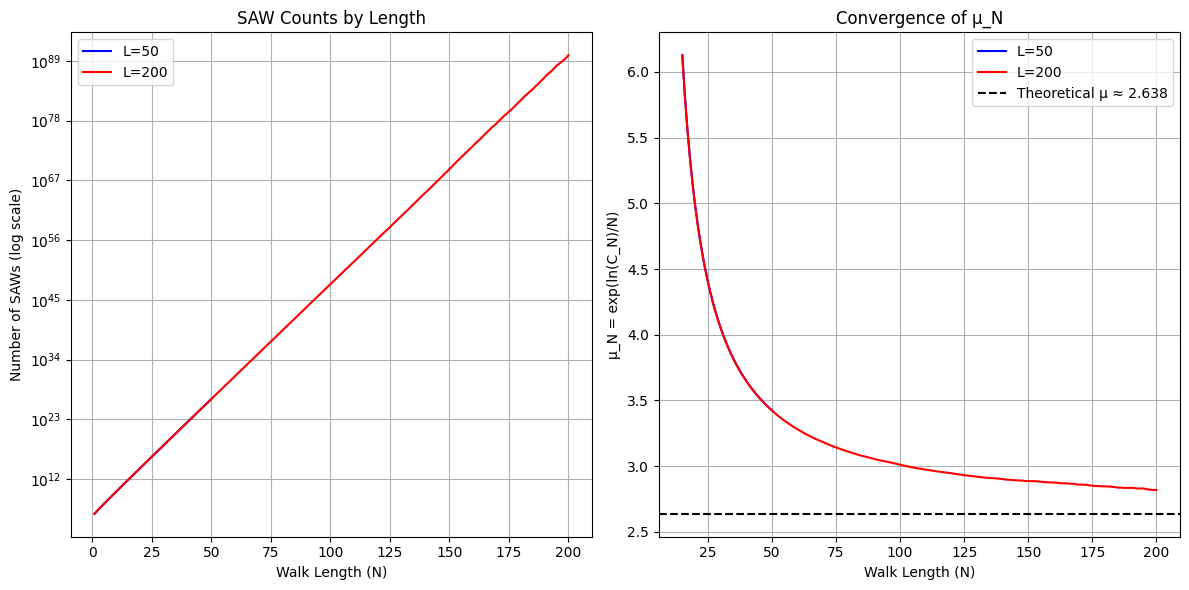

In [6]:
!pip install numba scipy
import numpy as np
from numba import cuda, int32, float64
import math
import time
from scipy.optimize import curve_fit

# ================== Configuration Parameters ==================
USE_LOCAL_MEM = True
LOCAL_MEM_MAX_LENGTH = 128

# ================== Collision Detection ==================
@cuda.jit(device=True)
def collision_check(walk: int32[:,:], length: int32, new_pos: int32[:], grid_size: int32) -> int32:
    """Check if new_pos collides with existing walk points."""
    for i in range(max(0, length-100), length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return 1
    if grid_size > 0:
        grid_x = new_pos[0] // grid_size
        grid_y = new_pos[1] // grid_size
        for i in range(length):
            dx = abs(walk[i,0] - new_pos[0])
            dy = abs(walk[i,1] - new_pos[1])
            if dx < grid_size and dy < grid_size:
                if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                    return 1
    else:
        for i in range(length):
            if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                return 1
    return 0

# ================== GPU Kernel ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states, global_walks):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return

    if max_length <= LOCAL_MEM_MAX_LENGTH and USE_LOCAL_MEM:
        walk = cuda.local.array(shape=(LOCAL_MEM_MAX_LENGTH, 2), dtype=int32)
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0
    else:
        walk = global_walks[wid]
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0

    directions = cuda.local.array(shape=(4,2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0
    directions[1,0], directions[1,1] = -1, 0
    directions[2,0], directions[2,1] = 0, 1
    directions[3,0], directions[3,1] = 0, -1

    rnd_state = random_states[wid]
    weight = 1.0
    current_length = 0
    new_pos = cuda.local.array(2, dtype=int32)

    while current_length < max_length:
        valid_count = 0
        valid_moves = cuda.local.array(4, dtype=int32)

        for d in range(4):
            new_pos[0] = walk[walk_length-1,0] + directions[d,0]
            new_pos[1] = walk[walk_length-1,1] + directions[d,1]
            if not collision_check(walk, walk_length, new_pos, 8):
                valid_moves[valid_count] = d
                valid_count += 1

        if valid_count == 0:
            break

        rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
        choice = int32((rnd_state / 4294967296.0) * valid_count)

        d = valid_moves[choice]
        walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
        walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
        walk_length += 1
        weight *= valid_count
        current_length += 1

        if weight > 1e100 or weight < 1e-100:
            break

        cuda.atomic.add(results, current_length, weight)

# ================== Main Control Class ==================
class AdaptivePERM:
    def __init__(self, max_length=50, num_walks=10000):
        """Initialize PERM simulator."""
        self.max_length = max_length
        self.num_walks = num_walks
        self.results = np.zeros(max_length+1, dtype=np.float64)
        self.global_walks = cuda.device_array(shape=(num_walks, max_length, 2), dtype=np.int32)
    
    def run(self):
        """Run GPU simulation."""
        threads = 256
        blocks = (self.num_walks + threads - 1) // threads
        
        random_states = np.random.randint(1, 2**31, size=self.num_walks, dtype=np.uint32)
        
        d_results = cuda.to_device(self.results)
        d_random_states = cuda.to_device(random_states)
        
        perm_gpu_kernel[blocks, threads](
            self.max_length,
            self.num_walks,
            d_results,
            d_random_states,
            self.global_walks  
        )
        
        self.results = d_results.copy_to_host()
        print(f"result: {self.results[1:self.max_length+1]}")
        return self.results[1:self.max_length+1]

    def estimate_constants(self, fit_start=15):
        """Estimate mu and gamma using curve_fit based on equation (2.13)."""
        # Prepare data for fitting
        lengths = np.arange(fit_start, self.max_length + 1)
        c_N = self.results[fit_start:self.max_length + 1]
        # Compute response: ln(C_N)/N, handle zeros/infs
        response = [np.log(max(c, 1e-10)) / N for c, N in zip(c_N, lengths)]
        
        # Define fitting function: ln(C_N)/N = log_mu + ((y-1) * ln(N))/N + A/N
        def fitting_func(N, log_mu, A, y):
            return log_mu + ((y-1) * np.log(N)) / N + A / N
        
        # Initial guess: log_mu ~ ln(2.638), A ~ 1.0, y ~ 1.344
        p0 = [np.log(2.638), 1.0, 1.344]
        
        try:
            # Perform curve fitting
            popt, pcov = curve_fit(fitting_func, lengths, response, p0=p0)
            log_mu_est, A_est, y_est = popt
            
            # Calculate estimated mu
            mu_est = np.exp(log_mu_est)
            
            # Calculate mu_N = exp(ln(C_N)/N) for analysis
            mu_N = [np.exp(np.log(max(c, 1e-10)) / N) for c, N in zip(c_N, lengths)]
            
            return mu_est, y_est, mu_N
        except RuntimeError:
            print("Curve fitting failed, returning NaN values.")
            return np.nan, np.nan, []

# ================== Test Example ==================
if __name__ == "__main__":
    print("=== Short Chain Test (L=50) ===")
    sim1 = AdaptivePERM(max_length=50, num_walks=100000)
    results1 = sim1.run()
    mu1, gamma1, mu_N1 = sim1.estimate_constants()
    print(f"μ = {mu1:.6f}, γ = {gamma1:.6f}")
    
    print("\n=== Long Chain Test (L=200) ===")
    sim2 = AdaptivePERM(max_length=200, num_walks=100000)
    start = time.time()
    results2 = sim2.run()
    gpu_time = time.time() - start
    mu2, gamma2, mu_N2 = sim2.estimate_constants()
    print(f"μ = {mu2:.6f}, γ = {gamma2:.6f}")
    print(f"GPU Time: {gpu_time:.3f}s")

    # Visualize results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    
    # Plot C_N
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, sim1.max_length+1), results1, 'b-', label='L=50')
    plt.plot(np.arange(1, sim2.max_length+1), results2, 'r-', label='L=200')
    plt.xlabel('Walk Length (N)')
    plt.ylabel('Number of SAWs (log scale)')
    plt.yscale('log')
    plt.title('SAW Counts by Length')
    plt.legend()
    plt.grid(True)
    
    # Plot mu_N
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(15, sim1.max_length+1), mu_N1, 'b-', label='L=50')
    plt.plot(np.arange(15, sim2.max_length+1), mu_N2, 'r-', label='L=200')
    plt.axhline(y=2.638, color='k', linestyle='--', label='Theoretical μ ≈ 2.638')
    plt.xlabel('Walk Length (N)')
    plt.ylabel('μ_N = exp(ln(C_N)/N)')
    plt.title('Convergence of μ_N')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

#### try even larger L, e.g, when L is 1000

=== Short Chain Test (L=50) ===
result: [4.00000000e+05 1.20000000e+06 3.60000000e+06 1.00009440e+07
 2.84165280e+07 7.79655240e+07 2.17051488e+08 5.91425388e+08
 1.62799211e+09 4.41202172e+09 1.20417600e+10 3.25050097e+10
 8.80432108e+10 2.37464142e+11 6.41462867e+11 1.72389863e+12
 4.64488636e+12 1.24628907e+13 3.34642911e+13 8.97737875e+13
 2.40790273e+14 6.44677518e+14 1.73032676e+15 4.62574067e+15
 1.23375616e+16 3.29723737e+16 8.81615020e+16 2.35156972e+17
 6.27425722e+17 1.67369972e+18 4.45891043e+18 1.18797662e+19
 3.17035101e+19 8.44972633e+19 2.25317602e+20 6.00520097e+20
 1.60045768e+21 4.26769822e+21 1.13684582e+22 3.03364488e+22
 8.08957106e+22 2.14878041e+23 5.72642684e+23 1.53126873e+24
 4.07434163e+24 1.08596993e+25 2.87555293e+25 7.62411347e+25
 2.01938811e+26 5.36159846e+26]
μ = 2.644611, γ = 1.270827

=== Long Chain Test (L=1000) ===
result: [4.00000000e+005 1.20000000e+006 3.60000000e+006 1.00098720e+007
 2.84156640e+007 7.81359480e+007 2.17500228e+008 5.92776468e+0

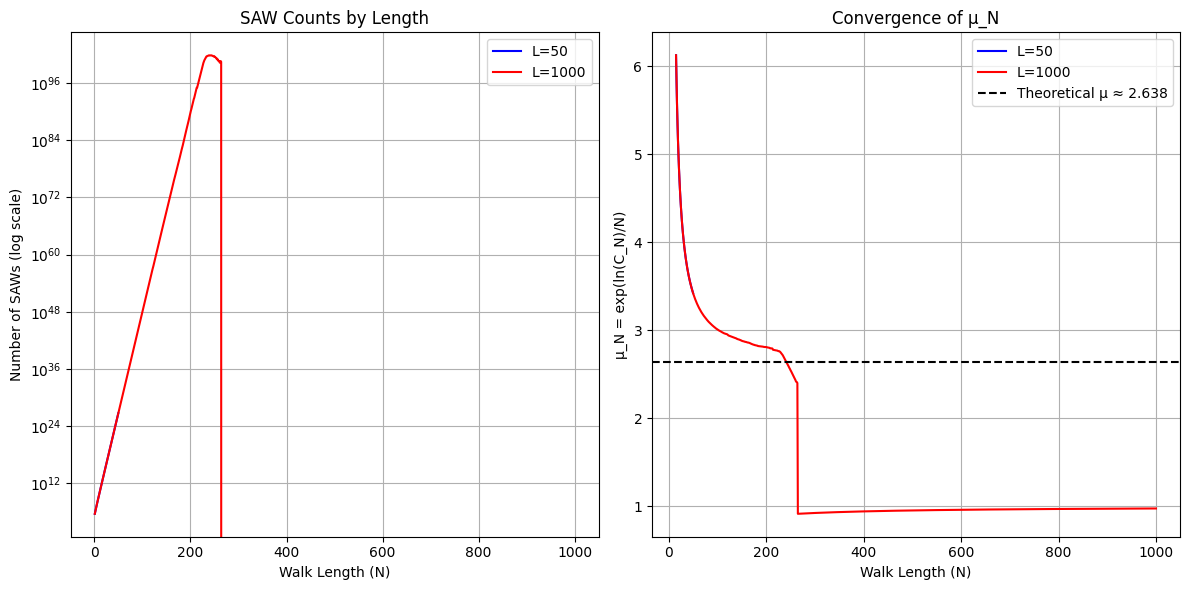

In [2]:
!pip install numba scipy
import numpy as np
from numba import cuda, int32, float64
import math
import time
from scipy.optimize import curve_fit

# ================== Configuration Parameters ==================
USE_LOCAL_MEM = True
LOCAL_MEM_MAX_LENGTH = 128

# ================== Collision Detection ==================
@cuda.jit(device=True)
def collision_check(walk: int32[:,:], length: int32, new_pos: int32[:], grid_size: int32) -> int32:
    """Check if new_pos collides with existing walk points."""
    for i in range(max(0, length-100), length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return 1
    if grid_size > 0:
        grid_x = new_pos[0] // grid_size
        grid_y = new_pos[1] // grid_size
        for i in range(length):
            dx = abs(walk[i,0] - new_pos[0])
            dy = abs(walk[i,1] - new_pos[1])
            if dx < grid_size and dy < grid_size:
                if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                    return 1
    else:
        for i in range(length):
            if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                return 1
    return 0

# ================== GPU Kernel ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states, global_walks):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return

    if max_length <= LOCAL_MEM_MAX_LENGTH and USE_LOCAL_MEM:
        walk = cuda.local.array(shape=(LOCAL_MEM_MAX_LENGTH, 2), dtype=int32)
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0
    else:
        walk = global_walks[wid]
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0

    directions = cuda.local.array(shape=(4,2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0
    directions[1,0], directions[1,1] = -1, 0
    directions[2,0], directions[2,1] = 0, 1
    directions[3,0], directions[3,1] = 0, -1

    rnd_state = random_states[wid]
    weight = 1.0
    current_length = 0
    new_pos = cuda.local.array(2, dtype=int32)

    while current_length < max_length:
        valid_count = 0
        valid_moves = cuda.local.array(4, dtype=int32)

        for d in range(4):
            new_pos[0] = walk[walk_length-1,0] + directions[d,0]
            new_pos[1] = walk[walk_length-1,1] + directions[d,1]
            if not collision_check(walk, walk_length, new_pos, 8):
                valid_moves[valid_count] = d
                valid_count += 1

        if valid_count == 0:
            break

        rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
        choice = int32((rnd_state / 4294967296.0) * valid_count)

        d = valid_moves[choice]
        walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
        walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
        walk_length += 1
        weight *= valid_count
        current_length += 1

        if weight > 1e100 or weight < 1e-100:
            break

        cuda.atomic.add(results, current_length, weight)

# ================== Main Control Class ==================
class AdaptivePERM:
    def __init__(self, max_length=50, num_walks=10000):
        """Initialize PERM simulator."""
        self.max_length = max_length
        self.num_walks = num_walks
        self.results = np.zeros(max_length+1, dtype=np.float64)
        self.global_walks = cuda.device_array(shape=(num_walks, max_length, 2), dtype=np.int32)
    
    def run(self):
        """Run GPU simulation."""
        threads = 256
        blocks = (self.num_walks + threads - 1) // threads
        
        random_states = np.random.randint(1, 2**31, size=self.num_walks, dtype=np.uint32)
        
        d_results = cuda.to_device(self.results)
        d_random_states = cuda.to_device(random_states)
        
        perm_gpu_kernel[blocks, threads](
            self.max_length,
            self.num_walks,
            d_results,
            d_random_states,
            self.global_walks  
        )
        
        self.results = d_results.copy_to_host()
        print(f"result: {self.results[1:self.max_length+1]}")
        return self.results[1:self.max_length+1]

    def estimate_constants(self, fit_start=15):
        """Estimate mu and gamma using curve_fit based on equation (2.13)."""
        # Prepare data for fitting
        lengths = np.arange(fit_start, self.max_length + 1)
        c_N = self.results[fit_start:self.max_length + 1]
        # Compute response: ln(C_N)/N, handle zeros/infs
        response = [np.log(max(c, 1e-10)) / N for c, N in zip(c_N, lengths)]
        
        # Define fitting function: ln(C_N)/N = log_mu + ((y-1) * ln(N))/N + A/N
        def fitting_func(N, log_mu, A, y):
            return log_mu + ((y-1) * np.log(N)) / N + A / N
        
        # Initial guess: log_mu ~ ln(2.638), A ~ 1.0, y ~ 1.344
        p0 = [np.log(2.638), 1.0, 1.344]
        
        try:
            # Perform curve fitting
            popt, pcov = curve_fit(fitting_func, lengths, response, p0=p0)
            log_mu_est, A_est, y_est = popt
            
            # Calculate estimated mu
            mu_est = np.exp(log_mu_est)
            
            # Calculate mu_N = exp(ln(C_N)/N) for analysis
            mu_N = [np.exp(np.log(max(c, 1e-10)) / N) for c, N in zip(c_N, lengths)]
            
            return mu_est, y_est, mu_N
        except RuntimeError:
            print("Curve fitting failed, returning NaN values.")
            return np.nan, np.nan, []

# ================== Test Example ==================
if __name__ == "__main__":
    print("=== Short Chain Test (L=50) ===")
    sim1 = AdaptivePERM(max_length=50, num_walks=100000)
    results1 = sim1.run()
    mu1, gamma1, mu_N1 = sim1.estimate_constants()
    print(f"μ = {mu1:.6f}, γ = {gamma1:.6f}")
    
    print("\n=== Long Chain Test (L=1000) ===")
    sim2 = AdaptivePERM(max_length=1000, num_walks=100000)
    start = time.time()
    results2 = sim2.run()
    gpu_time = time.time() - start
    mu2, gamma2, mu_N2 = sim2.estimate_constants()
    print(f"μ = {mu2:.6f}, γ = {gamma2:.6f}")
    print(f"GPU Time: {gpu_time:.3f}s")

    # Visualize results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    
    # Plot C_N
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, sim1.max_length+1), results1, 'b-', label='L=50')
    plt.plot(np.arange(1, sim2.max_length+1), results2, 'r-', label='L=1000')
    plt.xlabel('Walk Length (N)')
    plt.ylabel('Number of SAWs (log scale)')
    plt.yscale('log')
    plt.title('SAW Counts by Length')
    plt.legend()
    plt.grid(True)
    
    # Plot mu_N
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(15, sim1.max_length+1), mu_N1, 'b-', label='L=50')
    plt.plot(np.arange(15, sim2.max_length+1), mu_N2, 'r-', label='L=1000')
    plt.axhline(y=2.638, color='k', linestyle='--', label='Theoretical μ ≈ 2.638')
    plt.xlabel('Walk Length (N)')
    plt.ylabel('μ_N = exp(ln(C_N)/N)')
    plt.title('Convergence of μ_N')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

#### we can see this approach fails to work for higher L.
e.g, when L = 300, $weight \approx (2.638) ^ {300} \approx 10^{120}$, which is large than the threshold.

#### we use normalisation method instead to ensure its compatibility with high L value.
weight = $\prod_{i=0}^{L-1}(atmosphere(i) / 2.638)$ 


=== Test Case: L=50 ===
Results: [1516300.22747394 1724374.7848408  1961002.40877446 2064841.1288282
 2223051.71026032 2314962.22155769 2443931.53929857 2523681.23090923
 2630931.06880768 2704257.83352117 2795823.93061004 2863058.36771458
 2944566.38372226 3006165.79412216 3079562.63409407 3137739.76801637
 3205571.22872267 3260231.16020577 3323132.87943508 3374808.98732671
 3431119.24508043 3482098.73396332 3536438.67500559 3582597.1977708
 3633053.95641294 3677099.80229139 3723707.11398246 3766310.60917457
 3814205.34955234 3857294.36933117 3902060.73195865 3942173.71571122
 3987468.726976   4025369.59725447 4067164.06951653 4106577.68396605
 4146321.94558261 4184467.65750982 4223275.18298221 4261098.47349324
 4299740.3662009  4333686.25018584 4364589.05244045 4398064.72188608
 4435321.07416094 4466953.32370208 4498022.63953508 4527146.75459544
 4560825.44183171 4591123.80775344]
μ = 2.640241, γ = 1.309404
GPU Time: 0.863s

=== Test Case: L=500 ===
Results: [1.51630023e+06 1.7243747

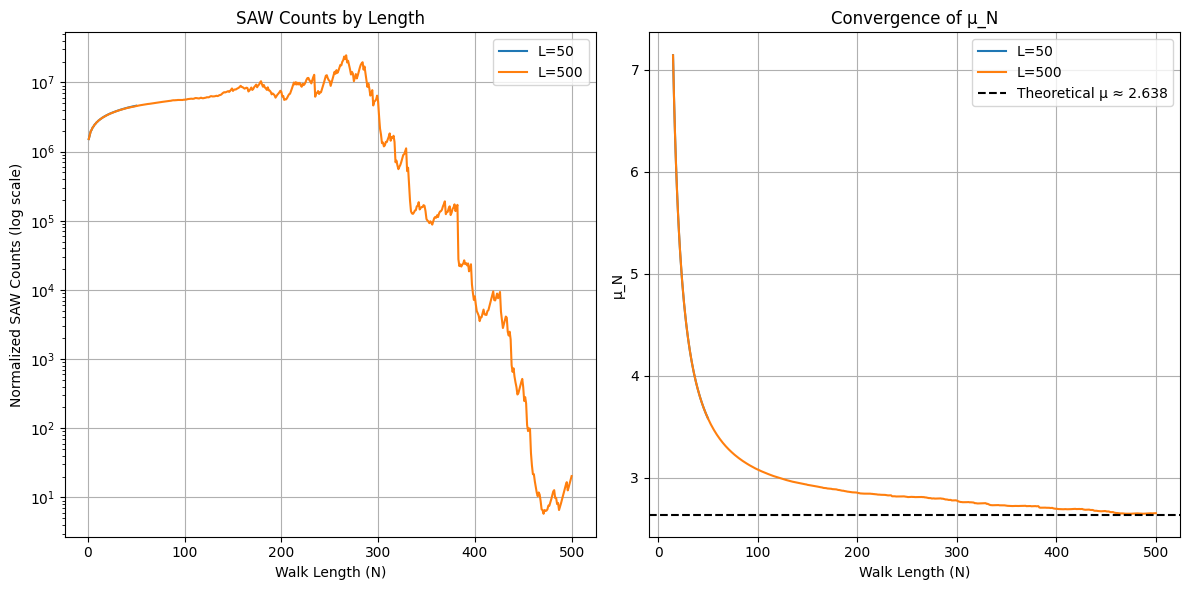

In [3]:
import numpy as np
from numba import cuda, int32, float64
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import time

# ================== Configuration Parameters ==================
USE_LOCAL_MEM = True
LOCAL_MEM_MAX_LENGTH = 128
MU_ESTIMATE = 2.638  # Initial estimate for normalization

# ================== Collision Detection ==================
@cuda.jit(device=True)
def collision_check(walk: int32[:,:], length: int32, new_pos: int32[:], grid_size: int32) -> int32:
    """Check if new_pos collides with existing walk points."""
    for i in range(max(0, length-100), length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return 1
    if grid_size > 0:
        grid_x = new_pos[0] // grid_size
        grid_y = new_pos[1] // grid_size
        for i in range(length):
            dx = abs(walk[i,0] - new_pos[0])
            dy = abs(walk[i,1] - new_pos[1])
            if dx < grid_size and dy < grid_size:
                if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                    return 1
    else:
        for i in range(length):
            if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                return 1
    return 0

# ================== GPU Kernel ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states, global_walks):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return

    if max_length <= LOCAL_MEM_MAX_LENGTH and USE_LOCAL_MEM:
        walk = cuda.local.array(shape=(LOCAL_MEM_MAX_LENGTH, 2), dtype=int32)
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0
    else:
        walk = global_walks[wid]
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0

    directions = cuda.local.array((4, 2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0
    directions[1,0], directions[1,1] = -1, 0
    directions[2,0], directions[2,1] = 0, 1
    directions[3,0], directions[3,1] = 0, -1

    rnd_state = random_states[wid]
    weight = 1.0
    current_length = 0
    new_pos = cuda.local.array(2, dtype=int32)

    while current_length < max_length:
        valid_count = 0
        valid_moves = cuda.local.array(4, dtype=int32)

        for d in range(4):
            new_pos[0] = walk[walk_length-1,0] + directions[d,0]
            new_pos[1] = walk[walk_length-1,1] + directions[d,1]
            if not collision_check(walk, walk_length, new_pos, 10):
                valid_moves[valid_count] = d
                valid_count += 1

        if valid_count == 0:
            break

        rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
        choice = int32((rnd_state / 4294967296.0) * valid_count)

        d = valid_moves[choice]
        walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
        walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
        walk_length += 1
        weight *= (valid_count / MU_ESTIMATE)  # Normalize per step
        current_length += 1

        if weight < 1e-200:  # Relaxed underflow threshold
            break

        cuda.atomic.add(results, current_length, weight)

# ================== Main Control Class ==================
class AdaptivePERM:
    def __init__(self, max_length=50, num_walks=10000):
        """Initialize PERM simulator."""
        self.max_length = max_length
        self.num_walks = num_walks
        self.results = np.zeros(max_length + 1, dtype=np.float64)
        self.global_walks = cuda.device_array((num_walks, max_length, 2), dtype=np.int32)

    def run(self):
        """Run GPU simulation."""
        threads = 256
        blocks = (self.num_walks + threads - 1) // threads
        random_states = np.random.randint(1, 2**31, size=self.num_walks, dtype=np.uint32)
        d_results = cuda.to_device(self.results)
        d_random_states = cuda.to_device(random_states)

        perm_gpu_kernel[blocks, threads](
            self.max_length,
            self.num_walks,
            d_results,
            d_random_states,
            self.global_walks
        )

        self.results = d_results.copy_to_host()
        print(f"Results: {self.results[1:self.max_length + 1]}")
        return self.results[1:self.max_length + 1]

    def estimate_constants(self, fit_start=15):
        """Estimate mu and gamma using curve_fit."""
        lengths = np.arange(fit_start, self.max_length + 1)
        if len(lengths) < 3:
            print(f"Warning: Not enough data points ({len(lengths)}), returning NaN.")
            return np.nan, np.nan, []

        c_N_adjusted = np.maximum(self.results[fit_start:self.max_length + 1], 1e-300)
        response = np.log(c_N_adjusted) + np.log(MU_ESTIMATE) * lengths

        def fitting_func(N, log_mu, A, gamma):
            return N * log_mu + (gamma - 1) * np.log(N) + A

        p0 = [np.log(MU_ESTIMATE), 1.0, 1.344]  # Initial guess: log(mu), A, gamma
        bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Ensure mu, gamma > 0
        try:
            popt, _ = curve_fit(fitting_func, lengths, response, p0=p0, bounds=bounds)
            log_mu_est, A_est, gamma_est = popt
            mu_est = np.exp(log_mu_est)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}, returning NaN values.")
            return np.nan, np.nan, []

        mu_N = [(c * MU_ESTIMATE ** N) ** (1 / N) for c, N in zip(c_N_adjusted, lengths)]
        return mu_est, gamma_est, mu_N

# ================== Test Cases ==================
if __name__ == "__main__":
    test_cases = [
        {"max_length": 50, "num_walks": 100000, "label": "L=50"},
        {"max_length": 500, "num_walks": 1000000, "label": "L=500"},
    ]

    results_all = []
    mu_N_all = []

    for case in test_cases:
        print(f"\n=== Test Case: {case['label']} ===")
        sim = AdaptivePERM(max_length=case["max_length"], num_walks=case["num_walks"])
        start = time.time()
        results = sim.run()
        mu, gamma, mu_N = sim.estimate_constants(fit_start=min(15, case["max_length"] // 2))
        gpu_time = time.time() - start
        print(f"μ = {mu:.6f}, γ = {gamma:.6f}")
        print(f"GPU Time: {gpu_time:.3f}s")
        results_all.append((results, case["label"]))
        mu_N_all.append((mu_N, case["label"], case["max_length"]))

    # Visualization
    plt.figure(figsize=(12, 6))

    # Plot C_N
    plt.subplot(1, 2, 1)
    for results, label in results_all:
        plt.plot(np.arange(1, len(results) + 1), results, label=label)
    plt.xlabel("Walk Length (N)")
    plt.ylabel("Normalized SAW Counts (C_N / (μ)^N)")
    plt.yscale("log")
    plt.title("SAW Counts by Length")
    plt.legend()
    plt.grid(True)

    # Plot mu_N
    plt.subplot(1, 2, 2)
    for mu_N, label, max_length in mu_N_all:
        plt.plot(np.arange(min(15, max_length // 2), max_length + 1), mu_N, label=label)
    plt.axhline(y=2.638, color="k", linestyle="--", label="Theoretical μ ≈ 2.638")
    plt.xlabel("Walk Length (N)")
    plt.ylabel("μ_N")
    plt.title("Convergence of μ_N")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Analysis from graph
When L is large, the chance of successfully sampling a SAW is very low, so it's necessary to increase the n_sample. That's why the graph of Normalised SAW counts suddenly drops when L is around 250 and increasing oscillation is observed.

#### see if increasing sample numbers work


=== Test Case: L=50 ===
Results: [151630.0227445  172437.47848151 196100.24088101 206376.54766588
 222246.75556075 231421.45863497 244421.87150157 252740.07454529
 263327.68728691 270619.60515443 279978.6100165  286617.52859039
 294994.96952793 301214.02939143 308159.2733946  314167.93904363
 320938.21802152 326135.14021534 332278.85484976 336666.86858566
 342721.97980958 347125.32884583 353208.07085345 358371.34872774
 363672.37649355 368194.09713526 373469.57354052 378445.71985883
 383952.7282778  389213.87642868 392886.97360058 397201.17345822
 401526.76688661 404618.76564427 408025.26483253 412119.75747841
 415743.14636355 418922.50026771 422173.40605922 427095.87637749
 430041.32082604 433319.91279219 436404.21034295 439673.89994081
 444610.15667593 446768.3887061  449446.01956542 452497.59757566
 453092.14318481 455431.6111952 ]
μ = 2.636523, γ = 1.350151
GPU Time: 1.806s

=== Test Case: L=500 ===
Results: [3.03260045e+06 3.44874957e+06 3.92200482e+06 4.12954102e+06
 4.44598338e

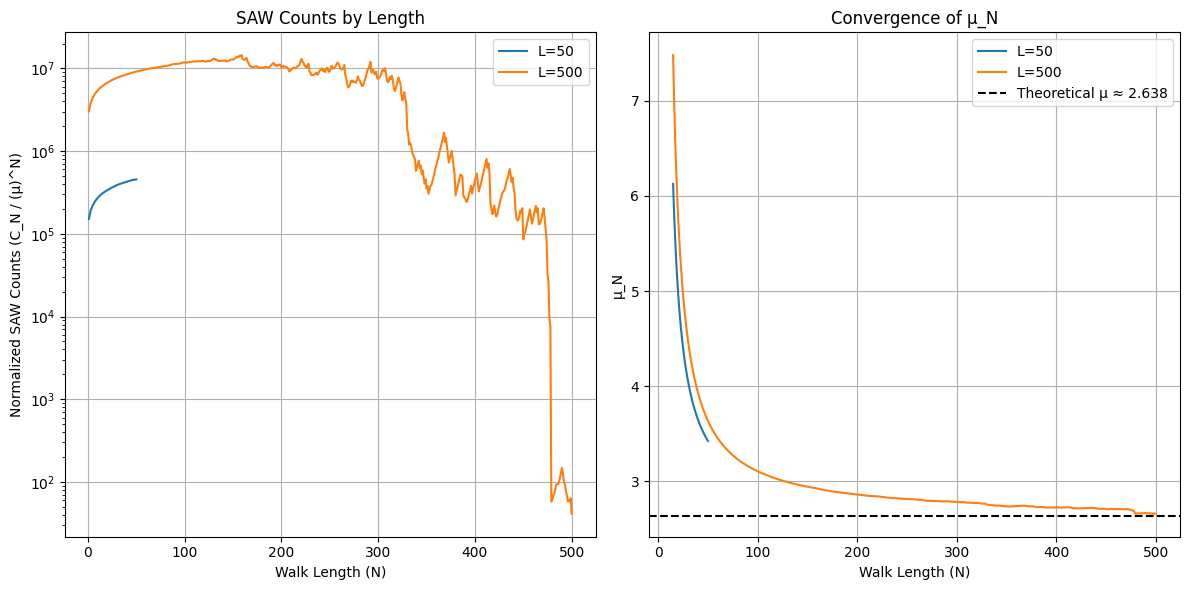

In [2]:
import numpy as np
from numba import cuda, int32, float64
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import time

# ================== Configuration Parameters ==================
USE_LOCAL_MEM = True
LOCAL_MEM_MAX_LENGTH = 128
MU_ESTIMATE = 2.638  # Initial estimate for normalization

# ================== Collision Detection ==================
@cuda.jit(device=True)
def collision_check(walk: int32[:,:], length: int32, new_pos: int32[:], grid_size: int32) -> int32:
    """Check if new_pos collides with existing walk points."""
    for i in range(max(0, length-100), length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return 1
    if grid_size > 0:
        grid_x = new_pos[0] // grid_size
        grid_y = new_pos[1] // grid_size
        for i in range(length):
            dx = abs(walk[i,0] - new_pos[0])
            dy = abs(walk[i,1] - new_pos[1])
            if dx < grid_size and dy < grid_size:
                if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                    return 1
    else:
        for i in range(length):
            if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                return 1
    return 0

# ================== GPU Kernel ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states, global_walks):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return

    if max_length <= LOCAL_MEM_MAX_LENGTH and USE_LOCAL_MEM:
        walk = cuda.local.array(shape=(LOCAL_MEM_MAX_LENGTH, 2), dtype=int32)
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0
    else:
        walk = global_walks[wid]
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0

    directions = cuda.local.array((4, 2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0
    directions[1,0], directions[1,1] = -1, 0
    directions[2,0], directions[2,1] = 0, 1
    directions[3,0], directions[3,1] = 0, -1

    rnd_state = random_states[wid]
    weight = 1.0
    current_length = 0
    new_pos = cuda.local.array(2, dtype=int32)

    while current_length < max_length:
        valid_count = 0
        valid_moves = cuda.local.array(4, dtype=int32)

        for d in range(4):
            new_pos[0] = walk[walk_length-1,0] + directions[d,0]
            new_pos[1] = walk[walk_length-1,1] + directions[d,1]
            if not collision_check(walk, walk_length, new_pos, 10):
                valid_moves[valid_count] = d
                valid_count += 1

        if valid_count == 0:
            break

        rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
        choice = int32((rnd_state / 4294967296.0) * valid_count)

        d = valid_moves[choice]
        walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
        walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
        walk_length += 1
        weight *= (valid_count / MU_ESTIMATE)  # Normalize per step
        current_length += 1

        if weight < 1e-200:  # Relaxed underflow threshold
            break

        cuda.atomic.add(results, current_length, weight)

# ================== Main Control Class ==================
class AdaptivePERM:
    def __init__(self, max_length=50, num_walks=10000):
        """Initialize PERM simulator."""
        self.max_length = max_length
        self.num_walks = num_walks
        self.results = np.zeros(max_length + 1, dtype=np.float64)
        self.global_walks = cuda.device_array((num_walks, max_length, 2), dtype=np.int32)

    def run(self):
        """Run GPU simulation."""
        threads = 256
        blocks = (self.num_walks + threads - 1) // threads
        random_states = np.random.randint(1, 2**31, size=self.num_walks, dtype=np.uint32)
        d_results = cuda.to_device(self.results)
        d_random_states = cuda.to_device(random_states)

        perm_gpu_kernel[blocks, threads](
            self.max_length,
            self.num_walks,
            d_results,
            d_random_states,
            self.global_walks
        )

        self.results = d_results.copy_to_host()
        print(f"Results: {self.results[1:self.max_length + 1]}")
        return self.results[1:self.max_length + 1]

    def estimate_constants(self, fit_start=15):
        """Estimate mu and gamma using curve_fit."""
        lengths = np.arange(fit_start, self.max_length + 1)
        if len(lengths) < 3:
            print(f"Warning: Not enough data points ({len(lengths)}), returning NaN.")
            return np.nan, np.nan, []

        c_N_adjusted = np.maximum(self.results[fit_start:self.max_length + 1], 1e-300)
        response = np.log(c_N_adjusted) + np.log(MU_ESTIMATE) * lengths

        def fitting_func(N, log_mu, A, gamma):
            return N * log_mu + (gamma - 1) * np.log(N) + A

        p0 = [np.log(MU_ESTIMATE), 1.0, 1.344]  # Initial guess: log(mu), A, gamma
        bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Ensure mu, gamma > 0
        try:
            popt, _ = curve_fit(fitting_func, lengths, response, p0=p0, bounds=bounds)
            log_mu_est, A_est, gamma_est = popt
            mu_est = np.exp(log_mu_est)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}, returning NaN values.")
            return np.nan, np.nan, []

        mu_N = [(c * MU_ESTIMATE ** N) ** (1 / N) for c, N in zip(c_N_adjusted, lengths)]
        return mu_est, gamma_est, mu_N

# ================== Test Cases ==================
if __name__ == "__main__":
    test_cases = [
        {"max_length": 50, "num_walks": 100000, "label": "L=50"},
        {"max_length": 500, "num_walks": 2000000, "label": "L=500"},
    ]

    results_all = []
    mu_N_all = []

    for case in test_cases:
        print(f"\n=== Test Case: {case['label']} ===")
        sim = AdaptivePERM(max_length=case["max_length"], num_walks=case["num_walks"])
        start = time.time()
        results = sim.run()
        mu, gamma, mu_N = sim.estimate_constants(fit_start=min(15, case["max_length"] // 2))
        gpu_time = time.time() - start
        print(f"μ = {mu:.6f}, γ = {gamma:.6f}")
        print(f"GPU Time: {gpu_time:.3f}s")
        results_all.append((results, case["label"]))
        mu_N_all.append((mu_N, case["label"], case["max_length"]))

    # Visualization
    plt.figure(figsize=(12, 6))

    # Plot C_N
    plt.subplot(1, 2, 1)
    for results, label in results_all:
        plt.plot(np.arange(1, len(results) + 1), results, label=label)
    plt.xlabel("Walk Length (N)")
    plt.ylabel("Normalized SAW Counts (C_N / (μ)^N)")
    plt.yscale("log")
    plt.title("SAW Counts by Length")
    plt.legend()
    plt.grid(True)

    # Plot mu_N
    plt.subplot(1, 2, 2)
    for mu_N, label, max_length in mu_N_all:
        plt.plot(np.arange(min(15, max_length // 2), max_length + 1), mu_N, label=label)
    plt.axhline(y=2.638, color="k", linestyle="--", label="Theoretical μ ≈ 2.638")
    plt.xlabel("Walk Length (N)")
    plt.ylabel("μ_N")
    plt.title("Convergence of μ_N")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


=== Test Case: L=100 ===
Results: [15163002.27491137 17243747.8457375  19610024.09135944 20649129.37890547
 22230288.00374599 23144865.61469868 24428233.98108148 25223709.73720251
 26289950.13180535 27017877.29627281 27934876.47107905 28604006.85541684
 29417968.00395049 30041719.52778336 30771585.82596196 31348246.57787857
 32018208.16527706 32563607.52338021 33186665.42146821 33700040.56111266
 34277556.49838359 34762286.69746682 35299675.47509454 35762304.94016686
 36279807.70440078 36721372.67743523 37210533.60668221 37631870.52695353
 38100363.58435012 38510467.1368667  38951216.99870318 39342115.28980345
 39769886.07764816 40149751.38244987 40571136.95784815 40934796.09088157
 41336807.03645839 41697376.54977002 42083961.07038146 42424175.13395341
 42807956.55841324 43150697.37688684 43500051.66713176 43836076.64015476
 44183924.56039851 44479331.16173931 44795371.1067139  45095494.29304379
 45428767.9982916  45725696.32655679 46023195.44245501 46304110.24911318
 46613480.444988

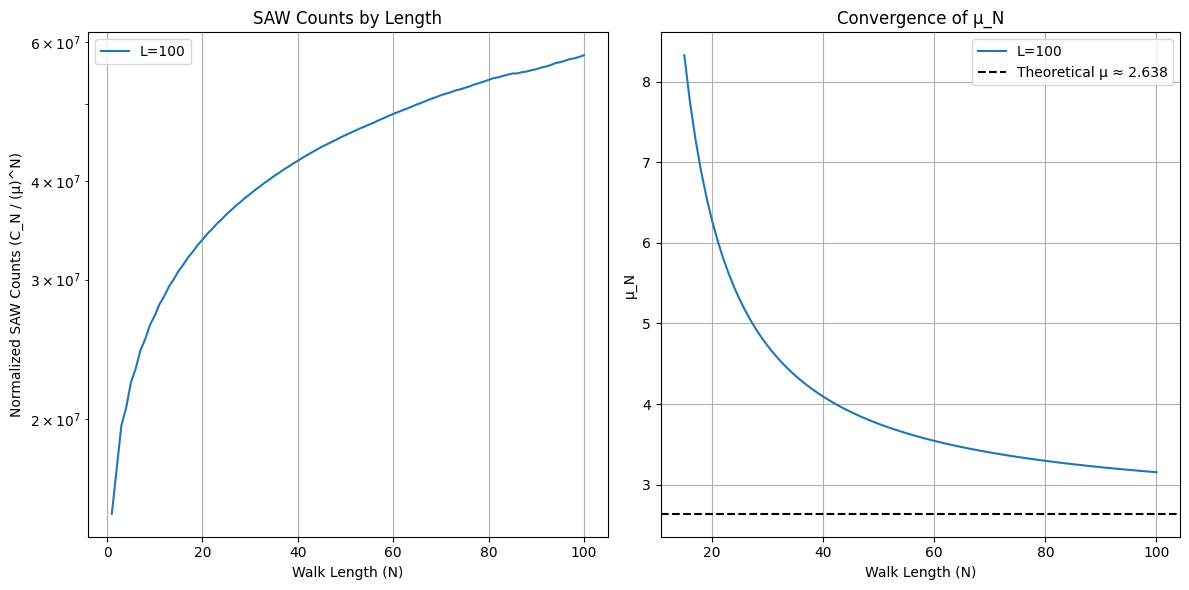

In [4]:
import numpy as np
from numba import cuda, int32, float64
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import time

# ================== Configuration Parameters ==================
USE_LOCAL_MEM = True
LOCAL_MEM_MAX_LENGTH = 128
MU_ESTIMATE = 2.638  # Initial estimate for normalization

# ================== Collision Detection ==================
@cuda.jit(device=True)
def collision_check(walk: int32[:,:], length: int32, new_pos: int32[:], grid_size: int32) -> int32:
    """Check if new_pos collides with existing walk points."""
    for i in range(max(0, length-100), length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return 1
    if grid_size > 0:
        grid_x = new_pos[0] // grid_size
        grid_y = new_pos[1] // grid_size
        for i in range(length):
            dx = abs(walk[i,0] - new_pos[0])
            dy = abs(walk[i,1] - new_pos[1])
            if dx < grid_size and dy < grid_size:
                if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                    return 1
    else:
        for i in range(length):
            if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                return 1
    return 0

# ================== GPU Kernel ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states, global_walks):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return

    if max_length <= LOCAL_MEM_MAX_LENGTH and USE_LOCAL_MEM:
        walk = cuda.local.array(shape=(LOCAL_MEM_MAX_LENGTH, 2), dtype=int32)
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0
    else:
        walk = global_walks[wid]
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0

    directions = cuda.local.array((4, 2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0
    directions[1,0], directions[1,1] = -1, 0
    directions[2,0], directions[2,1] = 0, 1
    directions[3,0], directions[3,1] = 0, -1

    rnd_state = random_states[wid]
    weight = 1.0
    current_length = 0
    new_pos = cuda.local.array(2, dtype=int32)

    while current_length < max_length:
        valid_count = 0
        valid_moves = cuda.local.array(4, dtype=int32)

        for d in range(4):
            new_pos[0] = walk[walk_length-1,0] + directions[d,0]
            new_pos[1] = walk[walk_length-1,1] + directions[d,1]
            if not collision_check(walk, walk_length, new_pos, 10):
                valid_moves[valid_count] = d
                valid_count += 1

        if valid_count == 0:
            break

        rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
        choice = int32((rnd_state / 4294967296.0) * valid_count)

        d = valid_moves[choice]
        walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
        walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
        walk_length += 1
        weight *= (valid_count / MU_ESTIMATE)  # Normalize per step
        current_length += 1

        if weight < 1e-200:  # Relaxed underflow threshold
            break

        cuda.atomic.add(results, current_length, weight)

# ================== Main Control Class ==================
class AdaptivePERM:
    def __init__(self, max_length=50, num_walks=10000):
        """Initialize PERM simulator."""
        self.max_length = max_length
        self.num_walks = num_walks
        self.results = np.zeros(max_length + 1, dtype=np.float64)
        self.global_walks = cuda.device_array((num_walks, max_length, 2), dtype=np.int32)

    def run(self):
        """Run GPU simulation."""
        threads = 256
        blocks = (self.num_walks + threads - 1) // threads
        random_states = np.random.randint(1, 2**31, size=self.num_walks, dtype=np.uint32)
        d_results = cuda.to_device(self.results)
        d_random_states = cuda.to_device(random_states)

        perm_gpu_kernel[blocks, threads](
            self.max_length,
            self.num_walks,
            d_results,
            d_random_states,
            self.global_walks
        )

        self.results = d_results.copy_to_host()
        print(f"Results: {self.results[1:self.max_length + 1]}")
        return self.results[1:self.max_length + 1]

    def estimate_constants(self, fit_start=15):
        """Estimate mu and gamma using curve_fit."""
        lengths = np.arange(fit_start, self.max_length + 1)
        if len(lengths) < 3:
            print(f"Warning: Not enough data points ({len(lengths)}), returning NaN.")
            return np.nan, np.nan, []

        c_N_adjusted = np.maximum(self.results[fit_start:self.max_length + 1], 1e-300)
        response = np.log(c_N_adjusted) + np.log(MU_ESTIMATE) * lengths

        def fitting_func(N, log_mu, A, gamma):
            return N * log_mu + (gamma - 1) * np.log(N) + A

        p0 = [np.log(MU_ESTIMATE), 1.0, 1.344]  # Initial guess: log(mu), A, gamma
        bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Ensure mu, gamma > 0
        try:
            popt, _ = curve_fit(fitting_func, lengths, response, p0=p0, bounds=bounds)
            log_mu_est, A_est, gamma_est = popt
            mu_est = np.exp(log_mu_est)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}, returning NaN values.")
            return np.nan, np.nan, []

        mu_N = [(c * MU_ESTIMATE ** N) ** (1 / N) for c, N in zip(c_N_adjusted, lengths)]
        return mu_est, gamma_est, mu_N

# ================== Test Cases ==================
if __name__ == "__main__":
    test_cases = [
        {"max_length": 100, "num_walks": 10000000, "label": "L=100"},
    ]

    results_all = []
    mu_N_all = []

    for case in test_cases:
        print(f"\n=== Test Case: {case['label']} ===")
        sim = AdaptivePERM(max_length=case["max_length"], num_walks=case["num_walks"])
        start = time.time()
        results = sim.run()
        mu, gamma, mu_N = sim.estimate_constants(fit_start=min(15, case["max_length"] // 2))
        gpu_time = time.time() - start
        print(f"μ = {mu:.16f}, γ = {gamma:.6f}")
        print(f"GPU Time: {gpu_time:.3f}s")
        results_all.append((results, case["label"]))
        mu_N_all.append((mu_N, case["label"], case["max_length"]))

    # Visualization
    plt.figure(figsize=(12, 6))

    # Plot C_N
    plt.subplot(1, 2, 1)
    for results, label in results_all:
        plt.plot(np.arange(1, len(results) + 1), results, label=label)
    plt.xlabel("Walk Length (N)")
    plt.ylabel("Normalized SAW Counts (C_N / (μ)^N)")
    plt.yscale("log")
    plt.title("SAW Counts by Length")
    plt.legend()
    plt.grid(True)

    # Plot mu_N
    plt.subplot(1, 2, 2)
    for mu_N, label, max_length in mu_N_all:
        plt.plot(np.arange(min(15, max_length // 2), max_length + 1), mu_N, label=label)
    plt.axhline(y=2.638, color="k", linestyle="--", label="Theoretical μ ≈ 2.638")
    plt.xlabel("Walk Length (N)")
    plt.ylabel("μ_N")
    plt.title("Convergence of μ_N")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Solution: we run several batches to ensure the sample size is enough for large L.

#### first run a small-scale test


=== Test Case: L=100 ===


Processing L=100: 100%|██████████| 100/100 [00:11<00:00,  9.04it/s]


Results: [15163002.27445011 17243747.8481505  19610024.08810124 20649058.76126277
 22229474.75436006 23142328.84665413 24428891.06099448 25224494.14546232
 26291502.49816257 27017577.19859152 27936929.31107533 28602731.07816601
 29415377.76469247 30035855.19408303 30771628.9974881  31351692.8390565
 32020939.90809644 32560030.69997779 33183887.12341215 33693171.1218463
 34275100.89002188 34756822.61866027 35300014.74434043 35762048.72395275
 36283033.62546311 36725513.52845462 37216813.56738144 37644458.39579195
 38113422.4140174  38518331.15572824 38969327.29227795 39358033.36152397
 39787518.15598377 40165507.83927897 40573071.71759637 40939047.835754
 41332998.61290205 41682680.7457218  42070261.3407781  42407252.3845973
 42776349.44786613 43093964.35980904 43441864.21299492 43772263.03182634
 44126407.4100178  44451528.47083466 44772784.30353823 45098485.50868845
 45429586.68716385 45728821.68884542 46046369.94264994 46340323.97733553
 46647881.92849642 46904399.63098591 47200542.6

Processing L=500: 100%|██████████| 500/500 [04:05<00:00,  2.04it/s]


Results: [7.58150114e+07 8.62187392e+07 9.80501204e+07 1.03247424e+08
 1.11153350e+08 1.15727042e+08 1.22156141e+08 1.26129124e+08
 1.31477797e+08 1.35105996e+08 1.39698510e+08 1.43039736e+08
 1.47102185e+08 1.50202213e+08 1.53870086e+08 1.56756071e+08
 1.60101709e+08 1.62816239e+08 1.65924316e+08 1.68498205e+08
 1.71397423e+08 1.73835919e+08 1.76578835e+08 1.78904550e+08
 1.81468655e+08 1.83685031e+08 1.86124284e+08 1.88239953e+08
 1.90547316e+08 1.92592834e+08 1.94819349e+08 1.96774114e+08
 1.98891770e+08 2.00796367e+08 2.02828954e+08 2.04677960e+08
 2.06638017e+08 2.08419039e+08 2.10333026e+08 2.12065160e+08
 2.13886405e+08 2.15553977e+08 2.17317965e+08 2.18923875e+08
 2.20621980e+08 2.22212275e+08 2.23888939e+08 2.25403938e+08
 2.27025532e+08 2.28505071e+08 2.30056736e+08 2.31512522e+08
 2.33033689e+08 2.34398448e+08 2.35880247e+08 2.37230093e+08
 2.38731656e+08 2.40086510e+08 2.41484886e+08 2.42780003e+08
 2.44173738e+08 2.45556683e+08 2.47010130e+08 2.48386668e+08
 2.49738349e+08

Processing L=1000: 100%|██████████| 1000/1000 [08:31<00:00,  1.95it/s]
<ipython-input-2-af6c82c6312f>:157: RuntimeWarning: overflow encountered in power
  mu_N = [(c * MU_ESTIMATE ** N) ** (1 / N) for c, N in zip(c_N_adjusted, lengths)]


Results: [1.51630023e+08 1.72437478e+08 1.96100241e+08 2.06494605e+08
 2.22305737e+08 2.31441204e+08 2.44302765e+08 2.52243496e+08
 2.62942102e+08 2.70198576e+08 2.79391442e+08 2.86082025e+08
 2.94196405e+08 3.00403781e+08 3.07741218e+08 3.13541845e+08
 3.20245563e+08 3.25691277e+08 3.31896250e+08 3.37012034e+08
 3.42811192e+08 3.47678235e+08 3.53111353e+08 3.57733873e+08
 3.62864979e+08 3.67264052e+08 3.72145365e+08 3.76408536e+08
 3.81044810e+08 3.85158341e+08 3.89595358e+08 3.93530065e+08
 3.97793652e+08 4.01545994e+08 4.05641266e+08 4.09251587e+08
 4.13156352e+08 4.16716747e+08 4.20473373e+08 4.23937090e+08
 4.27588484e+08 4.30865922e+08 4.34419237e+08 4.37667939e+08
 4.41111541e+08 4.44261501e+08 4.47592995e+08 4.50620988e+08
 4.53942562e+08 4.57031582e+08 4.60233355e+08 4.63210705e+08
 4.66371624e+08 4.69211537e+08 4.72252298e+08 4.75046762e+08
 4.77947238e+08 4.80743622e+08 4.83576732e+08 4.86273643e+08
 4.89116071e+08 4.91852552e+08 4.94687091e+08 4.97259409e+08
 4.99985465e+08

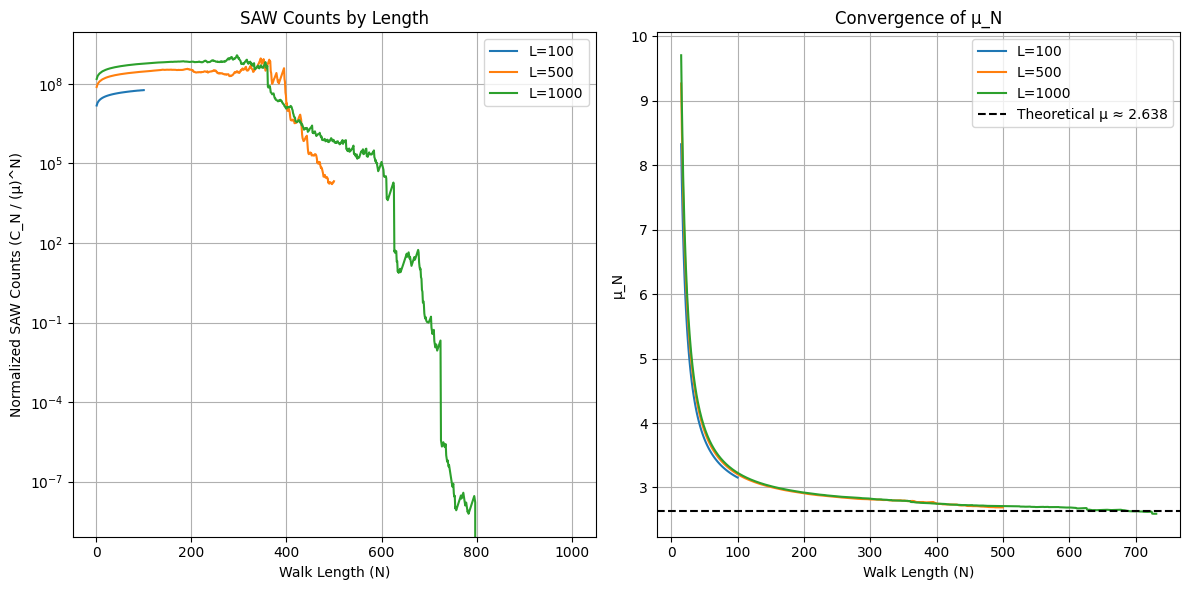

In [2]:
import numpy as np
from numba import cuda, int32, float64
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# ================== Configuration Parameters ==================
USE_LOCAL_MEM = True
LOCAL_MEM_MAX_LENGTH = 128
MU_ESTIMATE = 2.638  # Initial estimate for normalization

# ================== Collision Detection ==================
@cuda.jit(device=True)
def collision_check(walk: int32[:,:], length: int32, new_pos: int32[:], grid_size: int32) -> int32:
    """Check if new_pos collides with existing walk points."""
    for i in range(max(0, length-100), length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return 1
    if grid_size > 0:
        grid_x = new_pos[0] // grid_size
        grid_y = new_pos[1] // grid_size
        for i in range(length):
            dx = abs(walk[i,0] - new_pos[0])
            dy = abs(walk[i,1] - new_pos[1])
            if dx < grid_size and dy < grid_size:
                if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                    return 1
    else:
        for i in range(length):
            if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                return 1
    return 0

# ================== GPU Kernel ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states, global_walks):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return

    if max_length <= LOCAL_MEM_MAX_LENGTH and USE_LOCAL_MEM:
        walk = cuda.local.array(shape=(LOCAL_MEM_MAX_LENGTH, 2), dtype=int32)
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0
    else:
        walk = global_walks[wid]
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0

    directions = cuda.local.array((4, 2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0
    directions[1,0], directions[1,1] = -1, 0
    directions[2,0], directions[2,1] = 0, 1
    directions[3,0], directions[3,1] = 0, -1

    rnd_state = random_states[wid]
    weight = 1.0
    current_length = 0
    new_pos = cuda.local.array(2, dtype=int32)

    while current_length < max_length:
        valid_count = 0
        valid_moves = cuda.local.array(4, dtype=int32)

        for d in range(4):
            new_pos[0] = walk[walk_length-1,0] + directions[d,0]
            new_pos[1] = walk[walk_length-1,1] + directions[d,1]
            if not collision_check(walk, walk_length, new_pos, 10):
                valid_moves[valid_count] = d
                valid_count += 1

        if valid_count == 0:
            break

        rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
        choice = int32((rnd_state / 4294967296.0) * valid_count)

        d = valid_moves[choice]
        walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
        walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
        walk_length += 1
        weight *= (valid_count / MU_ESTIMATE)  # Normalize per step
        current_length += 1

        if weight < 1e-200:  # Relaxed underflow threshold
            break

        cuda.atomic.add(results, current_length, weight)

# ================== Main Control Class ==================
class AdaptivePERM:
    def __init__(self, max_length=50, batch_size=100000):
        """Initialize PERM simulator with batch processing."""
        self.max_length = max_length
        self.batch_size = batch_size
        # 动态调整批次数量：num_batches 与 max_length 成正比
        self.num_batches = max_length  # 保守策略：每个 L 对应一个批次单位
        self.results = np.zeros(max_length + 1, dtype=np.float64)

    def run(self):
        """Run GPU simulation in batches."""
        threads = 256
        blocks = (self.batch_size + threads - 1) // threads

        for batch in tqdm(range(self.num_batches), desc=f"Processing L={self.max_length}"):
            # 为当前批次分配 GPU 内存
            global_walks = cuda.device_array((self.batch_size, self.max_length, 2), dtype=np.int32)
            random_states = np.random.randint(1, 2**31, size=self.batch_size, dtype=np.uint32)
            d_random_states = cuda.to_device(random_states)
            d_results = cuda.device_array(self.max_length + 1, dtype=np.float64)

            # 运行 GPU 核函数
            perm_gpu_kernel[blocks, threads](
                self.max_length,
                self.batch_size,
                d_results,
                d_random_states,
                global_walks
            )

            # 累积结果并释放内存
            batch_results = d_results.copy_to_host()
            self.results += batch_results

            # 清理临时变量
            del global_walks, d_random_states, d_results

        print(f"Results: {self.results[1:self.max_length + 1]}")
        return self.results[1:self.max_length + 1]

    def estimate_constants(self, fit_start=15):
        """Estimate mu and gamma using curve_fit."""
        lengths = np.arange(fit_start, self.max_length + 1)
        if len(lengths) < 3:
            print(f"Warning: Not enough data points ({len(lengths)}), returning NaN.")
            return np.nan, np.nan, []

        c_N_adjusted = np.maximum(self.results[fit_start:self.max_length + 1], 1e-300)
        response = np.log(c_N_adjusted) + np.log(MU_ESTIMATE) * lengths

        def fitting_func(N, log_mu, A, gamma):
            return N * log_mu + (gamma - 1) * np.log(N) + A

        p0 = [np.log(MU_ESTIMATE), 1.0, 1.344]  # Initial guess: log(mu), A, gamma
        bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Ensure mu, gamma > 0
        try:
            popt, _ = curve_fit(fitting_func, lengths, response, p0=p0, bounds=bounds)
            log_mu_est, A_est, gamma_est = popt
            mu_est = np.exp(log_mu_est)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}, returning NaN values.")
            return np.nan, np.nan, []

        mu_N = [(c * MU_ESTIMATE ** N) ** (1 / N) for c, N in zip(c_N_adjusted, lengths)]
        return mu_est, gamma_est, mu_N

# ================== Test Cases ==================
if __name__ == "__main__":
    test_cases = [
        {"max_length": 100, "batch_size": 100000, "label": "L=100"},
        {"max_length": 500, "batch_size": 100000, "label": "L=500"},
        {"max_length": 1000, "batch_size": 100000, "label": "L=1000"},
    ]

    results_all = []
    mu_N_all = []

    for case in test_cases:
        print(f"\n=== Test Case: {case['label']} ===")
        sim = AdaptivePERM(max_length=case["max_length"], batch_size=case["batch_size"])
        start = time.time()
        results = sim.run()
        mu, gamma, mu_N = sim.estimate_constants(fit_start=min(15, case["max_length"] // 2))
        gpu_time = time.time() - start
        print(f"μ = {mu:.16f}, γ = {gamma:.6f}")
        print(f"GPU Time: {gpu_time:.3f}s")
        results_all.append((results, case["label"]))
        mu_N_all.append((mu_N, case["label"], case["max_length"]))

    # Visualization
    plt.figure(figsize=(12, 6))

    # Plot C_N
    plt.subplot(1, 2, 1)
    for results, label in results_all:
        plt.plot(np.arange(1, len(results) + 1), results, label=label)
    plt.xlabel("Walk Length (N)")
    plt.ylabel("Normalized SAW Counts (C_N / (μ)^N)")
    plt.yscale("log")
    plt.title("SAW Counts by Length")
    plt.legend()
    plt.grid(True)

    # Plot mu_N
    plt.subplot(1, 2, 2)
    for mu_N, label, max_length in mu_N_all:
        fit_start = min(15, max_length // 2)
        plt.plot(np.arange(fit_start, max_length + 1), mu_N, label=label)
    plt.axhline(y=2.638, color="k", linestyle="--", label="Theoretical μ ≈ 2.638")
    plt.xlabel("Walk Length (N)")
    plt.ylabel("μ_N")
    plt.title("Convergence of μ_N")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#### the method works as the $L_0$ value where oscillation increases occurs is much larger than previous runs.

#### the issues: 
1) are the saw counts result automatically averaged by the atomic.add operation?
2) why in the left graph, the results should be roughly $C_N$ / $\mu ^ N$ as the results (average weight) is the estimator of $C_N$, and $C_N \approx A * \mu ^ N * N ^ \gamma$, $C_N$ / $\mu ^ N \approx A * N^ \gamma$, so wrong shape?
3) still have 0 for large L near 1000, resulting in fitting where $\mu$ = 1.0, does this indicate still insufficient sampling?
4) when L is large, result will be near 0, will this result in loss of accuracy (we are using float64 here)? should be adjusted dynamically?
5) why would there be increasing oscillation after 220 always? 
6) is the fitting method right now accurate enough, very small deviation in $\mu$ could result in much larger $\gamma$ when L is large, should we change the fitting method?
7) the grid collision check failures might increase when L is large, should still add the for loop $O(L)$ method just in case.